Вспомогательный код

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
from sklearn.metrics import accuracy_score


%matplotlib inline
np.random.seed(10)

colors = ['red', "blue"]
labels_cmap = ListedColormap(colors, 2)
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
main_cmap = LinearSegmentedColormap.from_list("main_scheme", colors, N=300)

def show_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], s=120, color=labels_cmap(y))

def generate_simple_data(N, a, b, c, max_x=5, max_y=5):
    np.random.seed(10)
    X = np.random.rand(N, 2)
    X[:, 0] = X[:, 0] * max_x
    X[:, 1] = X[:, 1] * max_y
    y = np.zeros(N)
    y[X[:, 0] * a + X[:, 1] * b + c > 0] = 1
    #y[X[:, 0] * a + X[:, 1] * b + c < -m]= 0
    return X, y

def create_neuron(a, b, c, prob_output=False):
    if prob_output:
        return lambda x: sigmoid(a*x[:, 0] + b*x[:, 1] + c)
    else:
        return lambda x: a*x[:, 0] + b*x[:, 1] + c

def show_descision_boundary(clf, limits, binary=False, X=None, y=None, n_lines=10, show_lines=False,
                           figsize=(5, 5), ax=None):
    xs, ys = limits
    x_min, x_max = xs
    y_min, y_max = ys

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)

    if binary:
        Z = clf.predict_class(np.c_[xx.ravel(), yy.ravel()])
        norm = Normalize(vmin=0.,vmax=1.)
    else:
        Z = clf(np.c_[xx.ravel(), yy.ravel()])
        if clf.prob_output:
            norm = Normalize(vmin=0.,vmax=1.)
        else:
            norm = Normalize(vmin=-10.,vmax=10., clip=True)

    Z = Z.reshape(xx.shape)
    Z = Z.astype(np.float32)

    ax.contourf(xx, yy, Z, n_lines, alpha=0.4, cmap=main_cmap, norm=norm)
    if show_lines:
        cp = ax.contour(xx, yy, Z, n_lines)
        ax.clabel(cp, inline=True,
              fontsize=10, colors="green")

    if y is not None:
        X = np.array(X)
        y = np.array(y)
        ax.scatter(X[:, 0], X[:, 1], s=120, color=labels_cmap(y),
                   zorder=4)


def eval_clf(clf, X, y):
    acc = accuracy_score(clf.predict_class(X), y)
    print(f"Accuracy {acc}")
    return acc

def create_three_axes():
    fig = plt.figure(figsize=(20, 6))
    grid = plt.GridSpec(2, 5, wspace=1, hspace=0.5)
    first_neuron = fig.add_subplot(grid[0, 0])
    first_neuron.set_xlabel("$x_1$")
    first_neuron.set_ylabel("$x_2$")
    first_neuron.set_title("Выход первого нейрона")

    second_neuron = fig.add_subplot(grid[1, 0])
    second_neuron.set_xlabel("$x_1$")
    second_neuron.set_ylabel("$x_2$")
    second_neuron.set_title("Выход второго нейрона")

    third_neuron_interm = fig.add_subplot(grid[:, 1:3])
    third_neuron_interm.set_xlabel("$z_1$ (выход первого нейрона)")
    third_neuron_interm.set_ylabel("$z_1$ (выход вторго нейрона)")
    third_neuron_interm.set_title("С")

    third_neuron_x = fig.add_subplot(grid[:, 3:])
    third_neuron_x.set_xlabel("$x_1$ (исходные координаты)")
    third_neuron_x.set_ylabel("$x_2$ (исходные координаты)")
    third_neuron_x.set_title("Выход третьего нейрона в исходных координатах")

    return first_neuron, second_neuron, third_neuron_interm, third_neuron_x

def visualize(neural_net, X, y):
    n_lines = 5
    limits = [[-1, 11], [-1, 11]]

    first_neuron, second_neuron, third_neuron_interm, third_neuron_x = create_three_axes()

    show_descision_boundary(limits=limits, clf=neural_net.neuron1, binary=True,
                                    X=X,
                                    y=y,
                                    n_lines=1,
                                    show_lines=False, ax=first_neuron)

    show_descision_boundary(limits=limits, clf=neural_net.neuron2, binary=True,
                                    X=X,
                                    y=y,
                                    n_lines=1,
                                    show_lines=False, ax=second_neuron)

    show_descision_boundary(limits=[[-0.1, 1.1], [-0.1,1.1]], clf=neural_net.neuron3, binary=True,
                                    X=np.vstack([neural_net.neuron1(X),
                                                neural_net.neuron2(X)]).T,
                                    y=y,
                                    n_lines=1,
                                    show_lines=False, ax=third_neuron_interm)

    show_descision_boundary(limits=limits, clf=neural_net, binary=False,
                                    X=X,
                                    y=y,
                                    n_lines=50,
                                    show_lines=False, ax=third_neuron_x)


(mini) Нейронная сеть

В этом практическом задании вам предстоит реализовать нейронную сеть, состоящую из трех нейронов и решающую задачу схожую с описанной в лекции.

Мы возьмем за основу класс Neuron, который вы реализовывали ранее, и научимся комбинировать выходы отдельных нейронов для получения более сложной разделяющей границы.

In [73]:
# класс Neuron из прошлой практики
def sigmoid(x):
    return 1./(1.+np.exp(-x))

class Neuron:
    """
    Класс, реализующий нейрон
    """
    def __init__(self, a: float, b: float, c: float, prob_output: bool = True):
        """
        a,b,c -- коэффиценты (веса) нейрона
        prob_output -- если True, то, на выходе -- вероятности, если False -- логит

        """
        self.a = a
        self.b = b
        self.c = c
        self.prob_output = prob_output

    def calculate_logit(self, x: np.ndarray) -> np.ndarray:
        """
        x -- массив размера (N, 2), где N -- количество объектов.
             Первый столбец -- признак  x1, второй -- x2.

        Данный метод должен возвращать logit = a*x1 + b*x2 + c

        """
        assert np.ndim(x) == 2 and x.shape[1] == 2
        logit = None
        logit = self.a * x[:, 0] + self.b * x[:,1] + self.c
        return logit

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """
        x -- массив размера (N, 2), где N -- количество объектов.
             Первый столбец -- признак  x1, второй -- x2.

        Данный метод должен возвращать logit(x), если self.prob_output=False,
        и sigmoid(logit(x)) иначе

        """
        assert np.ndim(x) == 2 and x.shape[1] == 2
        logit = self.calculate_logit(x)

        if self.prob_output:
            output = sigmoid(logit)
        else:
            output = logit
        assert output.shape == (x.shape[0],), f"Output size must have following shape: {[x.shape[0],]}. Recieved: {output.shape}"
        return output

    def predict_class(self, x: np.ndarray) -> np.ndarray:
        """
        x -- массив размера (N, 2), где N -- количество объектов.
             Первый столбец -- признак  x1, второй -- x2.

        Данный метод должен возвращать предсказанный класс для
        каждого из N объектов -- 0 или 1.

        """
        logit = self.calculate_logit(x)
        predicted_classes = (logit > 0.0).astype(np.int32)

        assert predicted_classes.shape == (x.shape[0],), f"Output size must have following shape: {[x.shape[0],]}. Recieved: {output.shape}"
        return predicted_classes

    def __repr__(self):
        return f"Neuron description. Weights: a={self.a}, b={self.b}. Bias: c={self.c}."

Задание 1

Реализуйте метод calculate_logit класса ThreeNeuronsNeuralNe

In [112]:
from typing import List

class ThreeNeuronsNeuralNet(Neuron):
    """
    Нейронная сеть из трех нейронов.

    """
    def __init__(self, first_neuron_params: List[float],
                       second_neuron_params: List[float],
                       third_neuron_params: List[float]):
        """
        Для конструировани нейронной сети нам потребуются параметры трех нейронов,
        которые передаются в трех списках.

        Мы наследуемся от класса Neuron, т.к. нам нужно переопределить только
        пересчет логитов. Предсказания классов и вероятностей уже реализованы.

        """
        self.prob_output = True # фиксируем вероятностный выход
        self.neuron1 = Neuron(*first_neuron_params, prob_output = True) # конструируем первый нейрон, prob_output=True, это важно!
        self.neuron2 = Neuron(*second_neuron_params, prob_output = True) # конструируем второй нейрон, prob_output=True, это важно!
        self.neuron3 = Neuron(*third_neuron_params, prob_output = False) # конструируем третий нейрон
        print(third_neuron_params)
    def calculate_logit(self, x):
        #print(x[0])
        """
        x -- массив размера (N, 2), где N -- количество объектов.
             Первый столбец -- признак  x1, второй -- x2.
             Важно! Это исходные координаты!

        Этот метод должен вернуть логит предсказанный всей сетью
        Это можно сделать в 4 шага:
        1) Получить вероятности синего класса для исходных данных первым
           нейроном: вектор длины N -- z1
        2) Получить вероятности синего класса для исходных данных вторым
           нейроном: вектор длины N -- z2
        3) Склеить полученные вероятности: массив размера (N, 2) -- z1z2
           * вам может быть полезна функция np.vstack
        4) Получить логит(!, calculate_logit) третьего нейрона, примененного к z1z2 -- logit

        """
        z1 = None
        z2 = None
        z1z2 = None
        logit = None

        # < YOUR CODE STARTS HERE >
        
        z1 = self.neuron1(x)
        
        z2=self.neuron2(x) 
        
        z1z2=np.vstack([z1,z2]).T
      
        logit=self.neuron3(z1z2)
       

        return  logit

In [113]:
test_net = ThreeNeuronsNeuralNet([1,2,3], [4,5,6], [7,8,9])



test_input = np.array([[10, 20], [30, -40]])
test_net.calculate_logit(test_input)



#assert np.allclose(test_net.calculate_logit(test_input), np.array([24.,  9.]))
#print("Simple test passed")

[7, 8, 9]


array([24.,  9.])

Теперь посмотрим как выглядит разделяющая поверхность

[1.5, 1.5, -0.65]
Accuracy 1.0
Well done


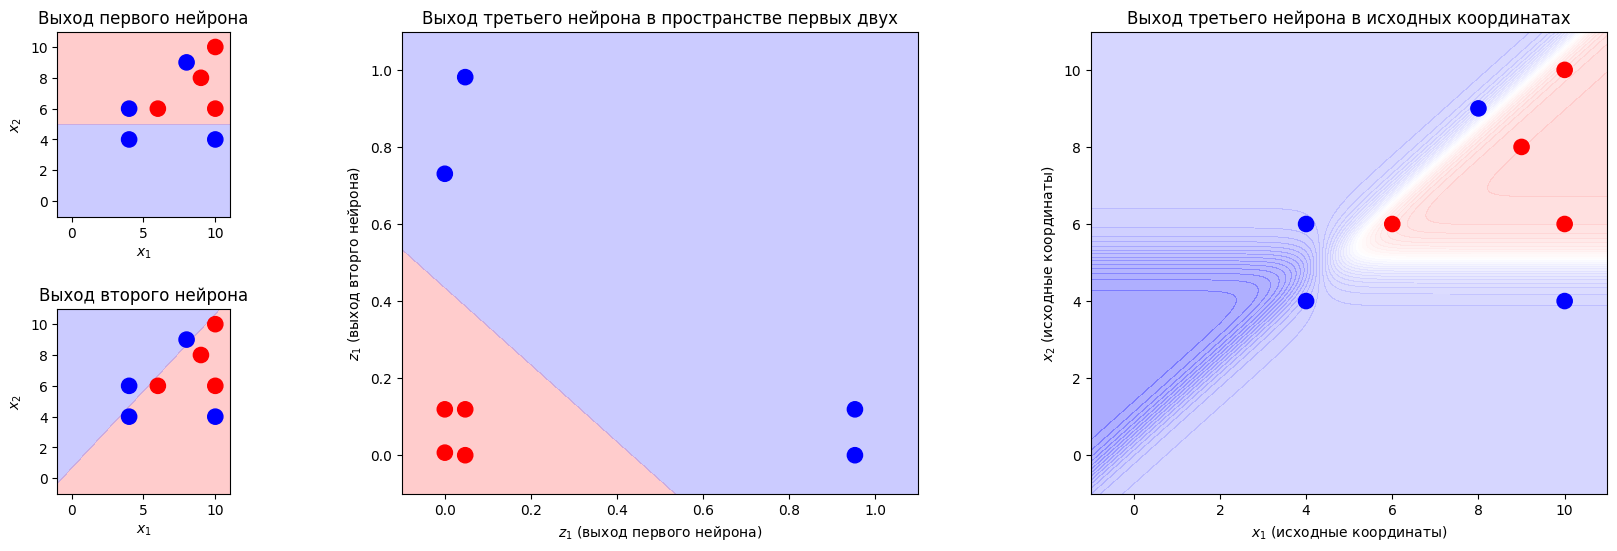

In [114]:
a1, b1, c1 = 0.0, -3.0, 15.0
a2, b2, c2 = -3.0, 3.0, -2.0
a3, b3, c3 = 1.5, 1.5, -0.65

neural_net = ThreeNeuronsNeuralNet([a1, b1, c1],
                                   [a2, b2, c2],
                                   [a3, b3, c3])

X = np.array([[10, 6], [6, 6], [9, 8], [10, 10],
              [10, 4], [4, 4], [4, 6], [8, 9]])
y = np.array([0, 0, 0, 0, 1, 1, 1, 1])

visualize(neural_net, X, y)

if eval_clf(neural_net, X, y) == 1:
    print("Well done")
else:
    print("Something went wrong")